# **Detección de Moho y Deterioro en Alimentos**

---
# **Entendimiento del caso**

## **1. Contexto**

La detección de **`frutas dañadas`** es muy importante para la **`producción agrícola`** y el procesamiento de frutas. Generalmente, esta detección se realiza manualmente, lo cual es un proceso ineficiente e impreciso.

Es por eso que en este proyecto se usará un conjunto de datos con muestras de **`guayabas`** en formato de imágenes de distintos tamaños. Las imágenes estarán separadas en dos directorios según si la fruta está fresca o podrida/deteriorada y se buscará clasificar dichas imágenes según su categoría correcta.

## **2. Categorías**

A continuación se muestra un ejemplo de cada una de las categorías de interés: Se puede evidenciar que la fruta fresca es más **`redonda y lisa`**, mientras que la podrida tiene **`manchas`** y está un poco **`deformada`**.

Otro aspecto importante es que las imágenes **`no tienen el mismo tamaño`** ni la misma forma, lo cual se ajustará más adelante en el preprocesamiento.

<center><img src = "https://drive.google.com/uc?id=1dIYE4VozxHlxV7LMkzvWp-V5VFFRcR25" alt = "fresh" width="280"></img> &emsp;&emsp; <img src = "https://drive.google.com/uc?id=1oLhezZfGHfvm16BaiunVgqW7G-1lBAen" alt = "rotten" width="320"></img></center>

---
# **Entendimiento de los datos**

## **1. Adquisición de datos**

In [68]:
# Librerías generales
import glob
import joblib
import numpy as np
import random

# Librerías de visión computacional y visualización
import cv2 as cv
import matplotlib as mpl
import matplotlib.pyplot as plt

# Métodos para modelamiento
import sklearn
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler

# Configuraciones
random.seed(42)
%matplotlib inline
plt.rcParams["figure.dpi"] = 110

Este material se realizó con las siguientes versiones:

- **`Python`**: 3.11.11
- **`Joblib`**: 1.4.2
- **`Numpy`**: 2.0.2
- **`OpenCV`**: 4.11.0
- **`Matplotlib`**: 3.10.0
- **`Scikit-learn`**: 1.6.1

In [71]:
!python --version
print("Joblib", joblib.__version__)
print("Numpy", np.__version__)
print("OpenCV", cv.__version__)
print("Matplotlib", mpl.__version__)
print("Scikit-learn", sklearn.__version__)

Python 3.11.11
Joblib 1.4.2
Numpy 2.0.2
OpenCV 4.11.0
Matplotlib 3.10.0
Scikit-learn 1.6.1


Lo primero es cargar las imágenes en **`escala de grises`**. Aquí se crean dos **`listas separadas`** para facilitar el etiquetado previo al entrenamiento.

In [ ]:
fresh_images = glob.glob("../imagenes/fresh/*.jpg")
rotten_images = glob.glob("../imagenes/rotten/*.jpg")

fresh = []
for fname in fresh_images:
    img = cv.imread(fname, cv.IMREAD_GRAYSCALE)
    fresh.append(img)

rotten = []
for fname in rotten_images:
    img = cv.imread(fname, cv.IMREAD_GRAYSCALE)
    rotten.append(img)

## **2. Análisis exploratorio de datos**

Se selecciona un elemento de cada lista (categoría) para una **`visualización inicial`**.

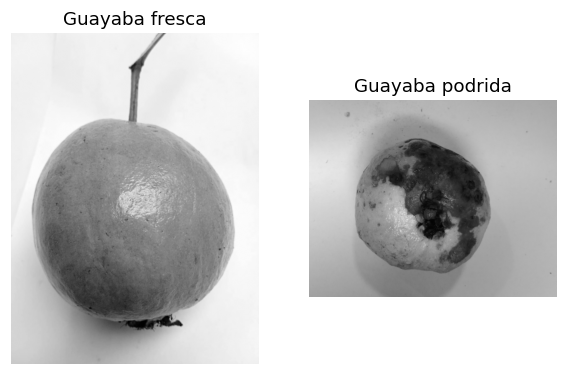

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.imshow(fresh[2], cmap="gray")
ax1.set_title(f"Guayaba fresca")
ax1.axis("off")
ax2.imshow(rotten[2], cmap="gray")
ax2.set_title(f"Guayaba podrida")
ax2.axis("off");

Ahora se revisa de forma general la **`composición`** del conjunto de datos. Con esto se puede detallar que hay $120$ imágenes de **`guayabas frescas`** en la primera lista y que cada imagen tiene **`dimensiones diferentes`**, como se había mencionado al inicio.

In [ ]:
print(f"Cantidad de imágenes (frescas): {len(fresh)}")
print(f"Tamaño de la primera imagen: {fresh[0].shape}")
print(f"Tamaño de la segunda imagen: {fresh[1].shape}")

Cantidad de imágenes (frescas): 120
Tamaño de la primera imagen: (976, 1089)
Tamaño de la segunda imagen: (1050, 1063)


De forma análoga, se revisa la segunda lista para ver que hay $150$ imágenes de **`guayabas podridas`**. Este conjunto de datos original está un poco **`desbalanceado`**, pero no será un problema mayor debido a la cantidad de imágenes que habrá luego del aumento de datos.

In [ ]:
print(f"Cantidad de imágenes (podridas): {len(rotten)}")
print(f"Tamaño de la primera imagen: {rotten[0].shape}")
print(f"Tamaño de la segunda imagen: {rotten[1].shape}")

Cantidad de imágenes (podridas): 150
Tamaño de la primera imagen: (3120, 4160)
Tamaño de la segunda imagen: (589, 661)


Por los resultados anteriores, se **`redimensionan`** las imágenes para que todas tengan un tamaño de $128 \times 128$ pixeles.

In [ ]:
for i, img in enumerate(fresh):
    fresh[i] = cv.resize(img, (128, 128), interpolation = cv.INTER_AREA)

for i, img in enumerate(rotten):
    rotten[i] = cv.resize(img, (128, 128), interpolation = cv.INTER_AREA)

---
# **Aumento de datos**

## **1. Rotaciones y acercamientos**

Las primeras transformaciones a aplicar son rotaciones y acercamientos aleatorios. Para esto, se transforma cada imagen con **`ocho combinaciones`** diferentes de ángulos y escalas y los resultados se van agregando a la lista de imágenes. De esta forma, quedan **`nueve versiones`** potencialmente distintas de cada imagen.

El proceso se realiza sobre ambas listas (frutas frescas y deterioradas).

In [ ]:
temp1 = fresh.copy()
for img in temp1:
    for i in range(8):
        angle = random.randrange(10, 360, 10) # Ángulo de rotación
        scale = random.uniform(1, 1.3) # Escala para el acercamiento/zoom
        mat = cv.getRotationMatrix2D((64, 64), angle, scale)
        fresh.append(cv.warpAffine(img, mat, (128, 128), flags=cv.INTER_LINEAR))

temp2 = rotten.copy()
for img in temp2:
    for i in range(8):
        angle = random.randrange(10, 360, 10)
        scale = random.uniform(1, 1.3)
        mat = cv.getRotationMatrix2D((64, 64), angle, scale)
        rotten.append(cv.warpAffine(img, mat, (128, 128)))

Se selecciona un elemento de cada lista y se muestran cuatro de sus transformaciones. Nótese que, efectivamente, cada una tiene un ángulo y un nivel de *zoom* distinto.

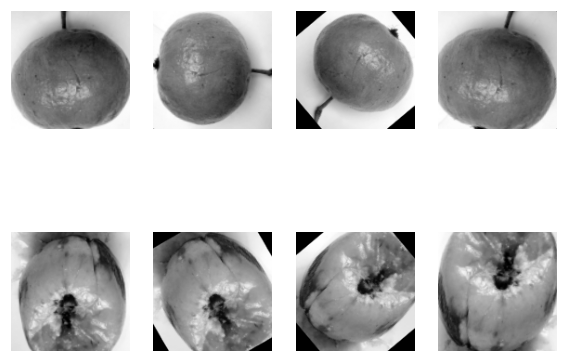

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=4)
for i in range(-1, -5, -1):
    axes[0, -i - 1].imshow(fresh[i], cmap="gray")
    axes[0, -i - 1].axis("off")
    axes[1, -i - 1].imshow(rotten[i], cmap="gray")
    axes[1, -i - 1].axis("off")

## **2. Traslaciones**

Para complementar el aumento de datos, también se aplican traslaciones sobre cada elementos. Para esto, se generan **`dos combinaciones`** de movimientos horizontales y verticales y los resultados se agregan a cada lista. Así, quedan **`tres versiones`** (en cuanto a traslación) de cada imagen.

In [ ]:
temp1 = fresh.copy()
for img in temp1:
    for i in range(2):
        x = random.randint(-25, 25) # Traslación horizontal
        y = random.randint(-25, 25) # Traslación vertical
        mat = np.float32([[1, 0, x], [0, 1, y]])
        fresh.append(cv.warpAffine(img, mat, (128, 128)))

temp2 = rotten.copy()
for img in temp2:
    for i in range(2):
        x = random.randint(-25, 25)
        y = random.randint(-25, 25)
        mat = np.float32([[1, 0, x], [0, 1, y]])
        rotten.append(cv.warpAffine(img, mat, (128, 128)))

De nuevo, se selecciona un elemento de cada lista y se muestran sus transformaciones.

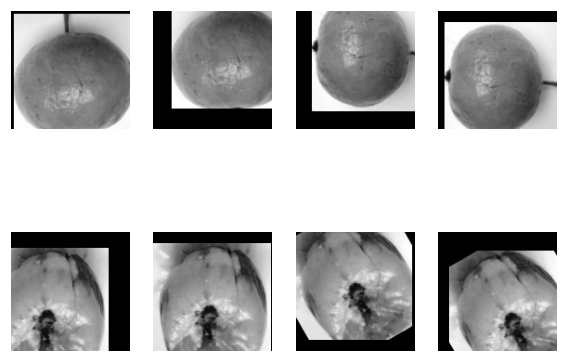

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=4)
for i in range(-1, -5, -1):
    axes[0, -i - 1].imshow(fresh[i], cmap="gray")
    axes[0, -i - 1].axis("off")
    axes[1, -i - 1].imshow(rotten[i], cmap="gray")
    axes[1, -i - 1].axis("off")

Finalmente se muestra la cantidad de imágenes que hay en cada lista luego de las transformaciones descritas anteriormente.

In [ ]:
print(f"Cantidad de imágenes (frescas): {len(fresh)}")
print(f"Cantidad de imágenes (podridas): {len(rotten)}")

Cantidad de imágenes (frescas): 3240
Cantidad de imágenes (podridas): 4050


---
# **Preparación de los datos**

A continuación se muestran, paso a paso, todas las transformaciones seleccionadas para dos **`imágenes de ejemplo`**.

En esta sección sólo se prepararán dichas imágenes porque las transformaciones se incluyen dentro del *pipeline* modular. Esto se hace para que el flujo de ejecución sea **`funcional`** y sólo se necesite pasar las **`imágenes crudas`** de $128 \times 128$ al objeto *Pipeline* que ya tendrá encapsuladas la secuencia de transformaciones, la selección de características y el modelo de clasificación.

## **1. Ecualización de histogramas**

Primero se ecualizan los histogramas de las imágenes para mejorar su contraste/iluminación.

Se crea una **`función`** que reciba los **`hiperparámetros`** del objeto CLAHE y aplique la transformación sobre un arreglo de imágenes para facilitar su posterior **`integración al pipeline`** de *scikit-learn*.

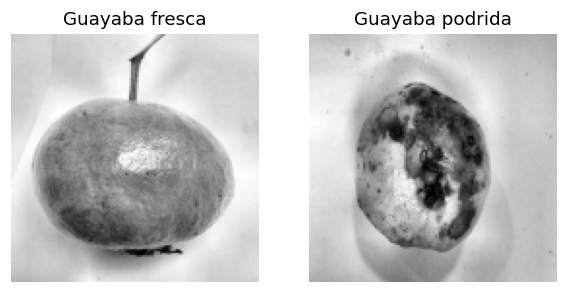

In [ ]:
def equalize(imgs, clipLimit=2.0, tileGridSize=(8, 8)):
    eq = []
    clahe = cv.createCLAHE(clipLimit, tileGridSize) # Contrast Limited Adaptive Histogram Equalization
    for img in imgs:
        eq.append(clahe.apply(img)) # Se aplica sobre cada imagen
    return eq

# Se transforman las imágenes de ejemplo
eq_fresh = equalize([fresh[2]])
eq_rotten = equalize([rotten[2]])

fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.imshow(eq_fresh[0], cmap="gray")
ax1.set_title(f"Guayaba fresca")
ax1.axis("off")
ax2.imshow(eq_rotten[0], cmap="gray")
ax2.set_title(f"Guayaba podrida")
ax2.axis("off");

## **2. Suavizado**

Ahora se aplica un **`filtro gaussiano`** para suavizar las imágenes. Igual que en el caso anterior, se define una función que reciba los hiperparámetros y aplique el filtro sobre una lista de imágenes.

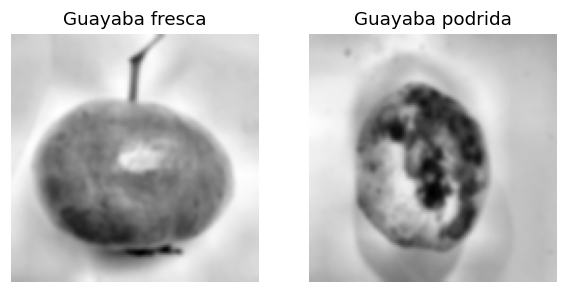

In [ ]:
def blur(imgs, ksize=(5, 5), sigmaX=0):
    blurred = []
    for img in imgs:
        blurred.append(cv.GaussianBlur(img, ksize, sigmaX)) # Filtro gaussiano
    return blurred

# Se transforman las imágenes de ejemplo
blurred_fresh = blur(eq_fresh)
blurred_rotten = blur(eq_rotten)

fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.imshow(blurred_fresh[0], cmap="gray")
ax1.set_title(f"Guayaba fresca")
ax1.axis("off")
ax2.imshow(blurred_rotten[0], cmap="gray")
ax2.set_title(f"Guayaba podrida")
ax2.axis("off");

## **3. Detección de bordes**

Finalmente, se define una función que usa el **`algoritmo de Canny`** para detectar los bordes en las imágenes seleccionadas.

Cabe mencionar que con esta última transformación se puede confirmar lo que se mencionó al inicio del proyecto sobre que las guayabas frescas son más lisas que las dañadas, ya que la detección de bordes resalta más las imperfecciones y el deterioro de estas.

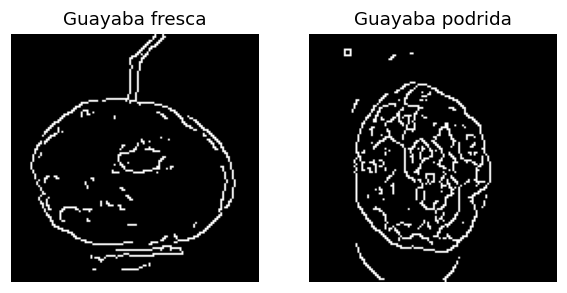

In [ ]:
def detect_edges(imgs, threshold=100):
    canny = []
    for img in imgs:
        canny.append(cv.Canny(img, threshold, threshold).flatten()) # Algoritmo de Canny
    return canny

# Se transforman las imágenes de ejemplo
canny_fresh = detect_edges(blurred_fresh)
canny_rotten = detect_edges(blurred_rotten)

fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.imshow(canny_fresh[0].reshape(128, 128), cmap="gray")
ax1.set_title(f"Guayaba fresca")
ax1.axis("off")
ax2.imshow(canny_rotten[0].reshape(128, 128), cmap="gray")
ax2.set_title(f"Guayaba podrida")
ax2.axis("off");

---
# **Modelamiento**

## **1. Partición de registros**

Ahora sí se unen las dos listas y se crean sus **`respectivas etiquetas`**.

In [ ]:
X = fresh + rotten
y = [0]*len(fresh) + [1]*len(rotten)

Se separan los datos de **`entrenamiento`** de los ejemplos con los que, posteriormente, se estimará el desempeño del modelo. Para esto se usará el $15\%$ de los registros en la evaluación de **`prueba`**.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=0.15, random_state=42, stratify=y)

## **2. Pipeline de ejecución**

En la construcción del *pipeline* se incluyen las tres transformaciones descritas anteriormente, seguidas de la **`normalización`** de los datos y la selección de las primeras $1000$ **`componentes principales`** (las cuales explican cerca del $60\%$ de la varianza total de las características).

Al final del flujo se agrega un **`bosque aleatorio`** como clasificador y se define una semilla para que los resultados de su entrenamiento sean replicables.

In [ ]:
estimators = [("equ", FunctionTransformer(equalize)), # Ecualización de histogramas
              ("blr", FunctionTransformer(blur)), # Suavizado
              ("edg", FunctionTransformer(detect_edges)), # Detección de bordes
              ("std", StandardScaler()), # Normalización
              ("pca", PCA(n_components=1000)), # Componentes principales
              ("clf", RandomForestClassifier(random_state=42))] # Clasificador

pipe = Pipeline(estimators)

## **3. Entrenamiento**

Durante el entrenamiento del modelo, se hará una **`búsqueda de hiperparámetros`** sobre el *Pipeline* de *scikit-learn*. Esto incluye el **`tamaño de los bloques`** para la ecualización, el **`umbral`** para la detección de bordes, el **`número de árboles de decisión`** que componen el clasificador y la **`porción de características`** que el modelo revisa para separar nuevas ramas.

In [ ]:
params = {"equ__kw_args": [{"tileGridSize": (8, 8)}, {"tileGridSize": (10, 10)}],
          "edg__kw_args": [{"threshold": 80}, {"threshold": 100}, {"threshold": 120}],
          "clf__n_estimators": [60, 80, 100],
          "clf__max_features": [0.2, 0.3, 0.4]}

Como se tienen $54$ combinaciones de hiperparámetros y el modelo usa $6$ particiones para **`validación cruzada`**, se deben entrenar $324$ versiones diferentes. Las **`métricas`** de entrenamiento y validación se muestran en cada paso y la **`mejor configuración`** de hiperparámetros se muestra al final.

In [38]:
grid_clf = GridSearchCV(pipe, params, cv=6, verbose=3, return_train_score=True)
grid_clf.fit(X_train, y_train)

Fitting 6 folds for each of 54 candidates, totalling 324 fits
[CV 1/6] END clf__max_features=0.2, clf__n_estimators=60, edg__kw_args={'threshold': 80}, equ__kw_args={'tileGridSize': (8, 8)};, score=(train=1.000, test=0.813) total time= 1.7min
[CV 2/6] END clf__max_features=0.2, clf__n_estimators=60, edg__kw_args={'threshold': 80}, equ__kw_args={'tileGridSize': (8, 8)};, score=(train=1.000, test=0.823) total time= 1.7min
[CV 3/6] END clf__max_features=0.2, clf__n_estimators=60, edg__kw_args={'threshold': 80}, equ__kw_args={'tileGridSize': (8, 8)};, score=(train=1.000, test=0.805) total time= 1.7min
[CV 4/6] END clf__max_features=0.2, clf__n_estimators=60, edg__kw_args={'threshold': 80}, equ__kw_args={'tileGridSize': (8, 8)};, score=(train=1.000, test=0.833) total time= 1.7min
[CV 5/6] END clf__max_features=0.2, clf__n_estimators=60, edg__kw_args={'threshold': 80}, equ__kw_args={'tileGridSize': (8, 8)};, score=(train=1.000, test=0.816) total time= 1.7min
[CV 6/6] END clf__max_features=0.

GridSearchCV(cv=6,
             estimator=Pipeline(steps=[('equ',
                                        FunctionTransformer(func=<function equalize at 0x793b4ea79260>)),
                                       ('blr',
                                        FunctionTransformer(func=<function blur at 0x793b4f441b20>)),
                                       ('edg',
                                        FunctionTransformer(func=<function detect_edges at 0x793b4e7007c0>)),
                                       ('std', StandardScaler()),
                                       ('pca', PCA(n_components=1000)),
                                       ('clf',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'clf__max_features': [0.2, 0.3, 0.4],
                         'clf__n_estimators': [60, 80, 100],
                         'edg__kw_args': [{'threshold': 80}, {'threshold': 100},
                                          {'threshold': 120}],
                         'equ__kw_args': [{'tileGridSize': (8, 8)},
                                          {'tileGridSize': (10, 10)}]},
             return_train_score=True, verbose=3)

Se guarda el **`mejor modelo`** para futuras aplicaciones.

In [41]:
joblib.dump(grid_clf, "model.pkl")

['model.pkl']

---
# **Evaluación de desempeño**

## **1. Evaluación**

Se evalúa el desempeño del **`mejor clasificador`** en validación y se muestran sus hiperparámetros.

In [42]:
print(f"Mejor score: {grid_clf.best_score_}")

print("\nMejor configuración de hiperparámetros:")
best = grid_clf.best_params_
for param in params.keys():
    print(f"\t{param[:3]} - {param[5:]}: {best[param]}")

Mejor score: 0.8384446970890834

Mejor configuración de hiperparámetros:
	equ - kw_args: {'tileGridSize': (8, 8)}
	edg - kw_args: {'threshold': 120}
	clf - n_estimators: 60
	clf - max_features: 0.2


Por último, se utilizan los registros que no hicieron parte del entrenamiento para evaluar el desempeño del modelo al clasificar **`datos desconocidos`**.

In [43]:
grid_clf.score(X_test, y_test)

0.8409506398537477

## **2. Análisis de resultados**

Se escogen dos **`imágenes aleatorias`** del conjunto de prueba y se predicen sus categorías. Con esto se evidencia que el modelo las está clasificando **`exitosamente`**.

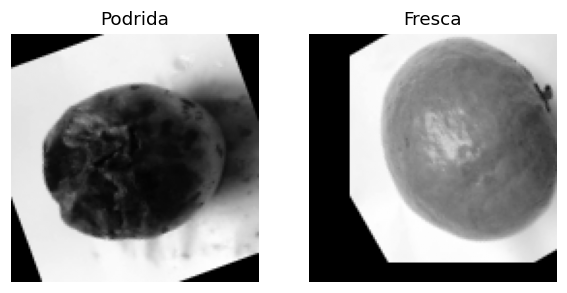

In [67]:
sample = np.array(random.sample(X_test.tolist(), 2)).astype(np.uint8)
preds = grid_clf.predict(sample)
labels = {0: "Fresca", 1: "Podrida"}

fig, axes = plt.subplots(ncols=2)
for i in range(2):
    axes[i].imshow(sample[i], cmap="gray")
    axes[i].set_title(labels[preds[i]])
    axes[i].axis("off")

Finalmente se encontró que el modelo entrenado obtuvo un **`desempeño satisfactorio`** al clasificar las imágenes de las guayabas en el conjunto de prueba, ya que se obtuvo un valor del $84.1\%$ para la métrica utilizada.

Adicionalmente, se notó que un tamaño de $(8, 8)$ fue la mejor alternativa para el bloque de ecualización (este es el valor por defecto) y un valor de $120$ fue lo mejor para el umbral del algoritmo de Canny.

Con respecto al clasificador, los **`mejores resultados`** se obtuvieron utilizando $60$ árboles de decisión y considerando el $20\%$ de las características en cada nodo.

---
# **Referencias**

- [Fresh and Rotten Fruits Dataset for Machine-Based Evaluation of Fruit Quality](https://data.mendeley.com/datasets/bdd69gyhv8/1)
- [glob - Unix style pathname pattern expansion](https://docs.python.org/3/library/glob.html)
- [Joblib - running Python functions as pipeline jobs](https://joblib.readthedocs.io/en/latest/index.html#module-joblib)
- [Matplotlib: Visualization with Python](https://matplotlib.org/)
- [Numpy](https://numpy.org/)
- [OpenCV-Python Tutorials](https://docs.opencv.org/4.x/d6/d00/tutorial_py_root.html)
- [scikit-learn: Machine Learning in Python](https://scikit-learn.org/stable/)

---
# **Créditos**

- Samuel David Moreno Vahos